In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



# 1. Data Understanding / Preparation

## 1.1 Data Retrieval

In [2]:
# Reading Accounts' Data
acc = pd.read_csv("./processed/account.csv", sep=";")

# Reading Transactions' Data
trans = pd.read_csv("./processed/trans_dev.csv", sep=";");

# Reading Loans' Data
loan = pd.read_csv("./processed/loan_dev.csv", sep=";");

# Reading Districts' Data
dist = pd.read_csv("./raw/district.csv", sep=";");

# Reading Disponents' Data
disp = pd.read_csv("./processed/disp.csv", sep=";");

# Reading Cards' Data
card = pd.read_csv("./processed/card_dev.csv", sep=";");

# Reading Clients' Data
clie = pd.read_csv("./processed/client.csv", sep=";");

In [3]:
# Confirming all files were read successfully.
# General overview of number of attributes (columns) and entries (rows) per table, missing values, types of variables.
for df in [acc, trans, loan, dist, disp, card, clie]:
    print(df.info())
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396685 entries, 0 to 396684
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   trans_id    396685 non-null  int64  
 1   account_id  396685 non-null  int64  
 2   date        396685 non-null  object 
 3   type        396685 non-null  object 
 4   operation   325924 non-null  object 
 5   amount      396685 non-null  float64
 6   balance     396685 non-null  float64
 7   k_symbol    211441 non-null  object 
 8   bank        97242 non-null   object 
 9   account    

## 1.2 Data Integration - Grouping all columns of all files into a single dataframe

In [4]:
# Merging Accounts' and Transactions' Data

complete = pd.merge(acc, pd.DataFrame(trans.groupby('account_id').size(), columns=['# trans']), right_index=True, left_on='account_id', how="outer")

# Oper 1 - credit in cash, Oper 2 - credit card withdrawal, Oper 3 - collection from another bank, Oper 4 - remittance to another bank, Oper 5 - withdrawal in cash
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit in cash'].groupby('account_id').size(), columns=['oper #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit card withdrawal'].groupby('account_id').size(), columns=['oper #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='collection from another bank'].groupby('account_id').size(), columns=['oper #3']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='remittance to another bank'].groupby('account_id').size(), columns=['oper #4']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='withdrawal in cash'].groupby('account_id').size(), columns=['oper #5']), right_index=True, left_on='account_id', how="outer")

# Type 1 - withdrawal, Type 2 - withdrawal in cash, Type 3 - credit 
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal'].groupby('account_id').size(), columns=['type #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal in cash'].groupby('account_id').size(), columns=['type #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='credit'].groupby('account_id').size(), columns=['type #3']), right_index=True, left_on='account_id', how="outer")

complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').amount.mean().round(2)).rename(columns={'amount':'avg trans amount'}), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').balance.mean().round(2)).rename(columns={'balance':'avg trans balance'}), right_index=True, left_on='account_id', how="outer")
# (4500, 15)

# ------------------------

# Merging with Loans' Data
complete = pd.merge(complete, loan.rename(columns={'date': 'loan date', 'amount': 'loan amount', 'duration': 'loan duration (mths)', 'payments': 'loan payments', 'status': 'loan status'}))
# (328, 21)

# ------------------------

# Merging with Districts' Data
complete = pd.merge(complete, dist.rename(columns={'code ': 'district_id', 'name ': 'district_name', 'region': 'district_region'}))
# (328, 36)

# ------------------------

# Merging Disp' and Cards' Data
disp = disp.rename(columns={"type": "disp type"})
disp['has disponent'] = np.where(disp['disp type'] == 'DISPONENT', True, False)
card = card.rename(columns={"type": "card type"})
disp_card = pd.merge(disp, card, how="outer")
# (5369, 9)

# ------------------------

# Merging Previous with Clients' Data
disp_card_clie = pd.merge(disp_card, clie).drop_duplicates(subset=['account_id']).drop(columns=['has disponent', 'disp type', 'district_id', 'disp_id'])
# (4500, 7)
temp = pd.merge(disp_card_clie, pd.DataFrame(disp_card.groupby('account_id').size(), columns = ['count owner']), right_index=True, left_on='account_id', how="outer")
disp_card_clie['has disponent'] = np.where(temp['count owner'] == 2, True, False)
# (4500, 8)

# ------------------------

# Merging Previous subset with the rest
complete = pd.merge(complete, disp_card_clie)


print(complete.shape)
complete


(328, 43)


,account_id,district_id,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan_id,loan date,loan amount,loan duration (mths),loan payments,loan status,district_name,district_region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,client_id,card_id,card type,issued,birthdate,sex,has disponent
0,5270,44,monthly issuance,1993-01-13,53.0,1.0,NaN,11.0,NaN,31.0,28.0,3.0,22.0,17600.36,69954.57,6077,1993-11-22,79608,24,3317,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6367,NaN,NaN,NaN,1970-04-28,M,False
1,5385,44,weekly issuance,1993-05-21,56.0,3.0,NaN,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,6103,1994-04-07,149340,60,2489,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6499,NaN,NaN,NaN,1963-02-01,M,False
2,8027,44,weekly issuance,1993-07-07,60.0,2.0,NaN,10.0,NaN,38.0,33.0,5.0,22.0,13255.80,55570.30,6642,1994-06-05,77640,12,6470,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,9915,NaN,NaN,NaN,1967-07-10,M,False
3,3037,44,monthly issuance,1994-05-26,117.0,26.0,NaN,NaN,NaN,71.0,70.0,1.0,46.0,10720.31,46487.00,5593,1996-04-18,277884,36,7719,-1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,3670,NaN,NaN,NaN,1980-09-17,F,False
4,10942,44,weekly issuance,1994-06-05,130.0,40.0,NaN,NaN,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,7227,1995-10-02,314520,60,5242,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,13451,NaN,NaN,NaN,1955-11-18,F,False
5,11265,15,monthly issuance,1993-01-14,43.0,14.0,NaN,NaN,8.0,14.0,22.0,NaN,21.0,3714.90,22198.18,7284,1993-09-15,52788,12,4399,1,Cesky Krumlov,south Bohemia,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,13845,NaN,NaN,NaN,1973-02-16,M,False
6,5927,15,monthly issuance,1993-11-26,33.0,3.0,NaN,6.0,NaN,12.0,11.0,1.0,21.0,4041.38,28362.25,6210,1994-06-06,87216,48,1817,-1,Cesky Krumlov,south Bohemia,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,7166,NaN,NaN,NaN,1964-05-13,M,False
7,4825,15,monthly issuance,1994-06-04,78.0,5.0,NaN,15.0,NaN,44.0,38.0,6.0,34.0,4644.44,30812.95,5980,1995-08-18,21396,12,1783,1,Cesky Krumlov,south Bohemia,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,5826,NaN,NaN,NaN,1968-09-09,M,True
8,5593,15,monthly issuance,1996-02-27,39.0,13.0,NaN,NaN,4.0,17.0,16.0,5.0,18.0,15332.39,53505.22,6144,1996-08-09,44376,12,3698,1,Cesky Krumlov,south Bohemia,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,6753,NaN,NaN,NaN,1962-05-23,M,False
9,10364,55,monthly issuance,1993-01-17,45.0,12.0,NaN,NaN,5.0,19.0,24.0,NaN,21.0,5957.54,34272.21,7121,1993-11-10,21924,36,609,1,Brno - venkov,south Moravia,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,12754,NaN,NaN,NaN,1960-08-20,M,True


### 1.2.1 Replacing by 0 columns refering to number of transactions (operations / types) that are NaN (weren't filled in

In [5]:
# NaN value is present in # operation / # type columns and represents that 0 were found. Therefore 0 is a more suitable value.
for col in ['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3']:
    complete[col] = complete[col].fillna(0)
    
complete.head()

,account_id,district_id,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan_id,loan date,loan amount,loan duration (mths),loan payments,loan status,district_name,district_region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,client_id,card_id,card type,issued,birthdate,sex,has disponent
0,5270,44,monthly issuance,1993-01-13,53.0,1.0,0.0,11.0,0.0,31.0,28.0,3.0,22.0,17600.36,69954.57,6077,1993-11-22,79608,24,3317,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6367,NaN,NaN,NaN,1970-04-28,M,False
1,5385,44,weekly issuance,1993-05-21,56.0,3.0,0.0,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,6103,1994-04-07,149340,60,2489,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,6499,NaN,NaN,NaN,1963-02-01,M,False
2,8027,44,weekly issuance,1993-07-07,60.0,2.0,0.0,10.0,0.0,38.0,33.0,5.0,22.0,13255.80,55570.30,6642,1994-06-05,77640,12,6470,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,9915,NaN,NaN,NaN,1967-07-10,M,False
3,3037,44,monthly issuance,1994-05-26,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,5593,1996-04-18,277884,36,7719,-1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,3670,NaN,NaN,NaN,1980-09-17,F,False
4,10942,44,weekly issuance,1994-06-05,130.0,40.0,0.0,0.0,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,7227,1995-10-02,314520,60,5242,1,Chrudim,east Bohemia,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,13451,NaN,NaN,NaN,1955-11-18,F,False


### 1.2.2 Deleting columns whose only purpose was to help in the join of tables (IDs) and/or are redundant

In [6]:
# Removing attributes. district_name / district_region are redundant because they can be derived by the rest of the district columns
complete = complete.drop(columns=['account_id', 'district_id', 'loan_id', 'district_name', 'district_region', 'client_id', 'card_id']).rename({'date': 'acc date'})

# Doesn't seem to be useful, especially considering the very limited amount of data related to cards
complete = complete.drop(columns=['issued'])

print(complete.shape)
complete.columns

(328, 35)


Index(['frequency', 'date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 ',
       'card type', 'birthdate', 'sex', 'has disponent'],
      dtype='object')

## 1.3 Complete ('joined') data

In [7]:
complete

,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan date,loan amount,loan duration (mths),loan payments,loan status,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,card type,birthdate,sex,has disponent
0,monthly issuance,1993-01-13,53.0,1.0,0.0,11.0,0.0,31.0,28.0,3.0,22.0,17600.36,69954.57,1993-11-22,79608,24,3317,1,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,NaN,1970-04-28,M,False
1,weekly issuance,1993-05-21,56.0,3.0,0.0,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,1994-04-07,149340,60,2489,1,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,NaN,1963-02-01,M,False
2,weekly issuance,1993-07-07,60.0,2.0,0.0,10.0,0.0,38.0,33.0,5.0,22.0,13255.80,55570.30,1994-06-05,77640,12,6470,1,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,NaN,1967-07-10,M,False
3,monthly issuance,1994-05-26,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,1996-04-18,277884,36,7719,-1,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,NaN,1980-09-17,F,False
4,weekly issuance,1994-06-05,130.0,40.0,0.0,0.0,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,1995-10-02,314520,60,5242,1,105606,77,26,7,2,7,53.0,8254,2.79,3.76,97,2166,2325,NaN,1955-11-18,F,False
5,monthly issuance,1993-01-14,43.0,14.0,0.0,0.0,8.0,14.0,22.0,0.0,21.0,3714.90,22198.18,1993-09-15,52788,12,4399,1,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,NaN,1973-02-16,M,False
6,monthly issuance,1993-11-26,33.0,3.0,0.0,6.0,0.0,12.0,11.0,1.0,21.0,4041.38,28362.25,1994-06-06,87216,48,1817,-1,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,NaN,1964-05-13,M,False
7,monthly issuance,1994-06-04,78.0,5.0,0.0,15.0,0.0,44.0,38.0,6.0,34.0,4644.44,30812.95,1995-08-18,21396,12,1783,1,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,NaN,1968-09-09,M,True
8,monthly issuance,1996-02-27,39.0,13.0,0.0,0.0,4.0,17.0,16.0,5.0,18.0,15332.39,53505.22,1996-08-09,44376,12,3698,1,58796,22,16,7,1,5,51.9,9045,3.13,3.60,124,1845,1879,NaN,1962-05-23,M,False
9,monthly issuance,1993-01-17,45.0,12.0,0.0,0.0,5.0,19.0,24.0,0.0,21.0,5957.54,34272.21,1993-11-10,21924,36,609,1,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894,NaN,1960-08-20,M,True


### 1.3.1 Exporting to csv

In [8]:
# complete.to_csv("./complete.csv", sep=";")

## 1.4 Data Analysis

### 1.4.1 Frequency - Nominal Categorical Attribute

In [9]:
complete['frequency'].describe()

count                  328
unique                   3
top       monthly issuance
freq                   259
Name: frequency, dtype: object

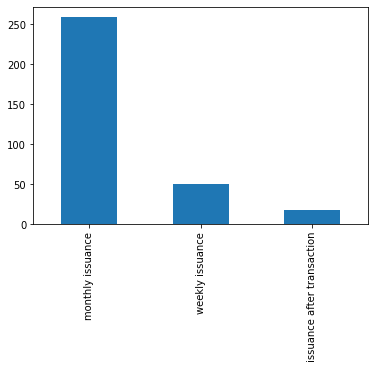

In [10]:
complete['frequency'].value_counts().plot(kind='bar')

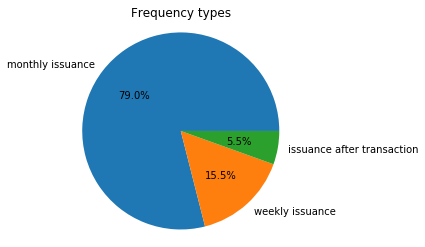

In [11]:
fig, ax = plt.subplots()
ax.pie(complete['frequency'].value_counts(), labels=complete['frequency'].unique(), autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Frequency types')

plt.show()

#### Remarks: 

### 1.4.2 Account Creation Date - Date Attribute

In [12]:
complete['date'].describe()

count            328
unique           286
top       1993-11-26
freq               4
Name: date, dtype: object

In [13]:
print("Min: ", end="");                 print(complete['date'].min())
print("Max: ", end="");                 print(complete['date'].max())

Min: 1993-01-13
Max: 1996-06-25


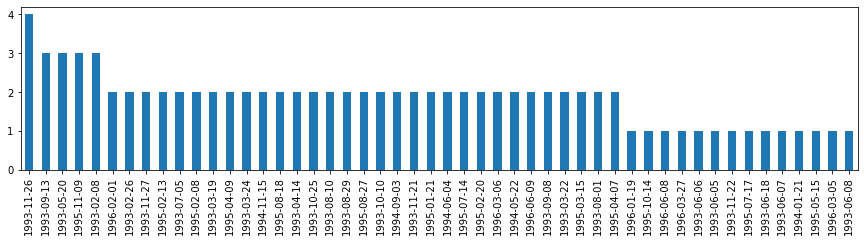

In [14]:
complete['date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks: 

### 1.4.3 Number of transactions - Numerical Attribute

In [15]:
q3, q1 = np.percentile(complete['# trans'], [75 ,25])

print("Min: ", end="");                 print(complete['# trans'].min())
print("Max: ", end="");                 print(complete['# trans'].max())
print("Mean: ", end="");                print(complete['# trans'].mean())
print("Median: ", end="");              print(complete['# trans'].median())
print("Standard deviation: ", end="");  print(complete['# trans'].std())
print("Skewness: ", end="");            print(complete['# trans'].skew())  
print("Variance: ", end="");            print(complete['# trans'].var())
print("Kurtosis: ", end="");            print(complete['# trans'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 4.0
Max: 196.0
Mean: 74.67682926829268
Median: 69.0
Standard deviation: 44.84385904325419
Skewness: 0.5601362519038949
Variance: 2010.9716938912509
Kurtosis: -0.44042695234757234
Interquartile Range: 64.5 | Q1: 39.0 | Q3: 103.5


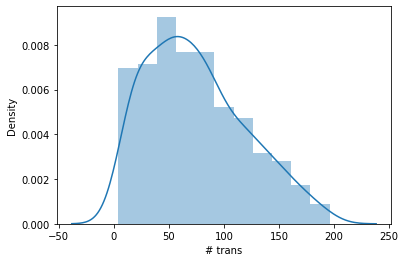

In [16]:
sns.distplot(complete['# trans'])

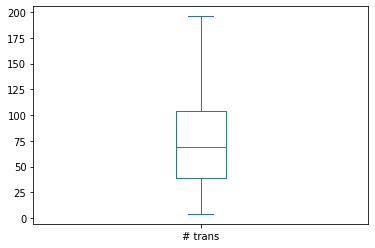

In [17]:
complete['# trans'].plot.box();

#### Remarks: 

### 1.4.4 Transaction Operations - Numerical Attributes

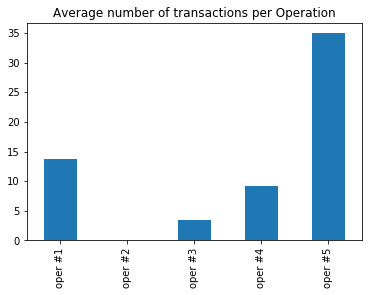

In [18]:
subset = complete[['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5']].mean()
subset.plot(kind='bar', title="Average number of transactions per Operation")

#### Remarks: 

### 1.4.5 Transaction Types - Numerical Attributes

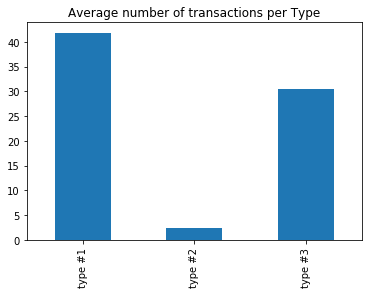

In [19]:
subset = complete[['type #1', 'type #2', 'type #3']].mean()
subset.plot(kind='bar', title="Average number of transactions per Type")

#### Remarks: 

### 1.4.6 Average Transaction Amount - Numerical Attribute

In [20]:
q3, q1 = np.percentile(complete['avg trans amount'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans amount'].min())
print("Max: ", end="");                 print(complete['avg trans amount'].max())
print("Mean: ", end="");                print(complete['avg trans amount'].mean())
print("Median: ", end="");              print(complete['avg trans amount'].median())
print("Standard deviation: ", end="");  print(complete['avg trans amount'].std())
print("Skewness: ", end="");            print(complete['avg trans amount'].skew())  
print("Variance: ", end="");            print(complete['avg trans amount'].var())
print("Kurtosis: ", end="");            print(complete['avg trans amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 1577.49
Max: 24948.66
Mean: 9533.910884146342
Median: 9058.369999999999
Standard deviation: 4221.392811650361
Skewness: 0.4365405986756821
Variance: 17820157.270253345
Kurtosis: -0.14506949259929636
Interquartile Range: 6406.2125000000015 | Q1: 6281.674999999999 | Q3: 12687.8875


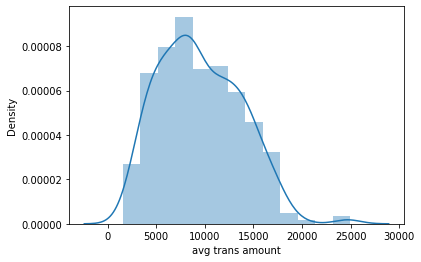

In [21]:
sns.distplot(complete['avg trans amount'])

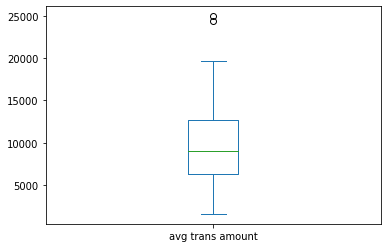

In [22]:
complete['avg trans amount'].plot.box();

#### Remarks: 

### 1.4.7 Average Transaction Balance - Numerical Attribute

In [23]:
q3, q1 = np.percentile(complete['avg trans balance'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans balance'].min())
print("Max: ", end="");                 print(complete['avg trans balance'].max())
print("Mean: ", end="");                print(complete['avg trans balance'].mean())
print("Median: ", end="");              print(complete['avg trans balance'].median())
print("Standard deviation: ", end="");  print(complete['avg trans balance'].std())
print("Skewness: ", end="");            print(complete['avg trans balance'].skew())  
print("Variance: ", end="");            print(complete['avg trans balance'].var())
print("Kurtosis: ", end="");            print(complete['avg trans balance'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 12250.0
Max: 76232.7
Mean: 43292.897103658535
Median: 42183.6
Standard deviation: 13280.43555218965
Skewness: 0.23392463075665093
Variance: 176369968.45586282
Kurtosis: -0.7022089819371335
Interquartile Range: 20420.417500000003 | Q1: 32592.165 | Q3: 53012.582500000004


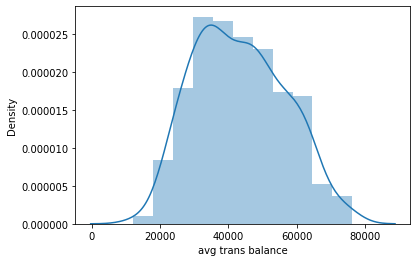

In [24]:
sns.distplot(complete['avg trans balance'])

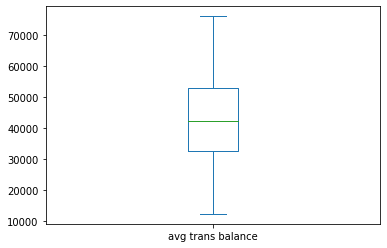

In [25]:
complete['avg trans balance'].plot.box();

#### Remarks:

### 1.4.8 Loan Date - Date Attribute

In [26]:
complete['loan date'].describe()

count            328
unique           283
top       1996-10-29
freq               3
Name: loan date, dtype: object

In [27]:
print("Min: ", end="");                 print(complete['loan date'].min())
print("Max: ", end="");                 print(complete['loan date'].max())

Min: 1993-07-05
Max: 1996-12-27


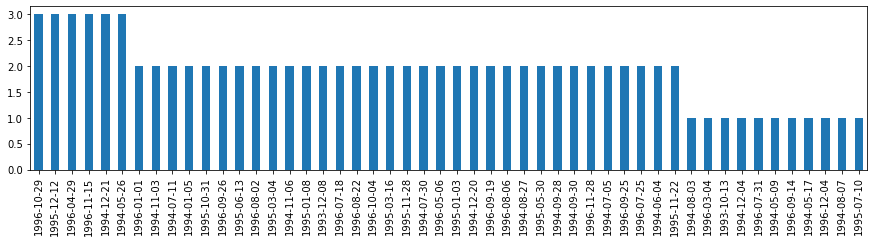

In [28]:
complete['loan date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

### 1.4.8.1 Age at Loan Date - Numerical Attribute

In [29]:
complete['age at loan (Years)'] = (pd.to_datetime(complete['loan date']) - pd.to_datetime(complete['birthdate'])).dt.total_seconds() / (365.25*24*3600)

In [30]:
q3, q1 = np.percentile(complete['age at loan (Years)'], [75 ,25])

print("Min: ", end="");                 print(complete['age at loan (Years)'].min())
print("Max: ", end="");                 print(complete['age at loan (Years)'].max())
print("Mean: ", end="");                print(complete['age at loan (Years)'].mean())
print("Median: ", end="");              print(complete['age at loan (Years)'].median())
print("Standard deviation: ", end="");  print(complete['age at loan (Years)'].std())
print("Skewness: ", end="");            print(complete['age at loan (Years)'].skew())  
print("Variance: ", end="");            print(complete['age at loan (Years)'].var())
print("Kurtosis: ", end="");            print(complete['age at loan (Years)'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 13.574264202600958
Max: 60.815879534565376
Mean: 36.25369359443081
Median: 35.51129363449692
Standard deviation: 12.54487416556144
Skewness: 0.09356797458962429
Variance: 157.37386782977086
Kurtosis: -1.1047773022669136
Interquartile Range: 21.28268309377139 | Q1: 25.446954140999317 | Q3: 46.729637234770706


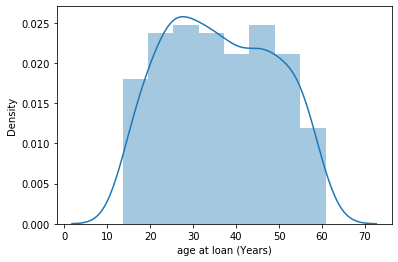

In [31]:
sns.distplot(complete['age at loan (Years)'])

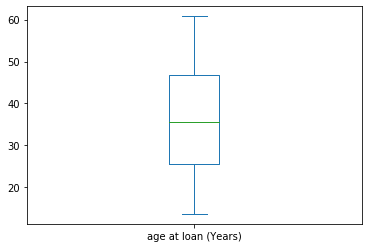

In [32]:
complete['age at loan (Years)'].plot.box()

#### Remarks: 

### 1.4.9 Loan Amount - Numerical Attribute

In [33]:
q3, q1 = np.percentile(complete['loan amount'], [75 ,25])

print("Min: ", end="");                 print(complete['loan amount'].min())
print("Max: ", end="");                 print(complete['loan amount'].max())
print("Mean: ", end="");                print(complete['loan amount'].mean())
print("Median: ", end="");              print(complete['loan amount'].median())
print("Standard deviation: ", end="");  print(complete['loan amount'].std())
print("Skewness: ", end="");            print(complete['loan amount'].skew())  
print("Variance: ", end="");            print(complete['loan amount'].var())
print("Kurtosis: ", end="");            print(complete['loan amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# Very High std which indicates that the data is spread out and not clustered around the mean
# > 1 therefore it is skewed to the right

Min: 4980
Max: 538500
Mean: 145308.6219512195
Median: 114804.0
Standard deviation: 105247.31809757082
Skewness: 1.0811084015092238
Variance: 11076997966.73126
Kurtosis: 0.8306938043642567
Interquartile Range: 130272.0 | Q1: 68328.0 | Q3: 198600.0


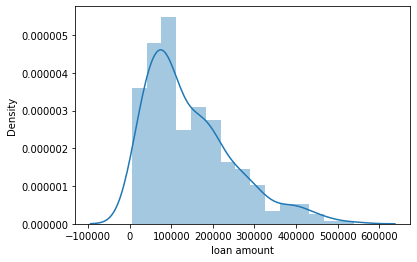

In [34]:
sns.distplot(complete['loan amount'])

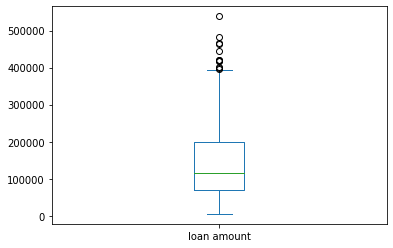

In [35]:
complete['loan amount'].plot.box();

#### Remarks:

### 1.4.10 Loan Duration (in months) - Numerical Attribute

In [36]:
q3, q1 = np.percentile(complete['loan duration (mths)'], [75 ,25])

print("Min: ", end="");                 print(complete['loan duration (mths)'].min())
print("Max: ", end="");                 print(complete['loan duration (mths)'].max())
print("Mean: ", end="");                print(complete['loan duration (mths)'].mean())
print("Median: ", end="");              print(complete['loan duration (mths)'].median())
print("Standard deviation: ", end="");  print(complete['loan duration (mths)'].std())
print("Skewness: ", end="");            print(complete['loan duration (mths)'].skew())  
print("Variance: ", end="");            print(complete['loan duration (mths)'].var())
print("Kurtosis: ", end="");            print(complete['loan duration (mths)'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 12
Max: 60
Mean: 35.853658536585364
Median: 36.0
Standard deviation: 16.73475166172723
Skewness: 0.05589223008522363
Variance: 280.0519131796823
Kurtosis: -1.2671912803874055
Interquartile Range: 24.0 | Q1: 24.0 | Q3: 48.0


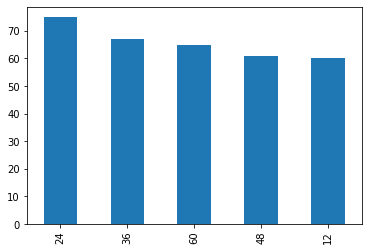

In [37]:
complete['loan duration (mths)'].value_counts().plot(kind='bar')

#### Remarks:

### 1.4.11 Loan Payments - Numerical Attribute

In [38]:
q3, q1 = np.percentile(complete['loan payments'], [75 ,25])

print("Min: ", end="");                 print(complete['loan payments'].min())
print("Max: ", end="");                 print(complete['loan payments'].max())
print("Mean: ", end="");                print(complete['loan payments'].mean())
print("Median: ", end="");              print(complete['loan payments'].median())
print("Standard deviation: ", end="");  print(complete['loan payments'].std())
print("Skewness: ", end="");            print(complete['loan payments'].skew())  
print("Variance: ", end="");            print(complete['loan payments'].var())
print("Kurtosis: ", end="");            print(complete['loan payments'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 319
Max: 9689
Mean: 4150.932926829269
Median: 3878.5
Standard deviation: 2193.620988539039
Skewness: 0.26933938573516064
Variance: 4811973.0413589915
Kurtosis: -0.8465605235895723
Interquartile Range: 3539.0 | Q1: 2368.75 | Q3: 5907.75


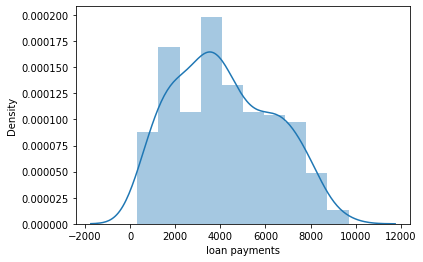

In [39]:
sns.distplot(complete['loan payments'])

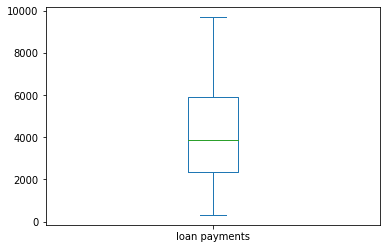

In [40]:
complete['loan payments'].plot.box();

#### Remarks:

### 1.4.12 Loan Status - Nominal(?) Attribute

In [41]:
complete['loan status'].describe()

count    328.000000
mean       0.719512
std        0.695541
min       -1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: loan status, dtype: float64

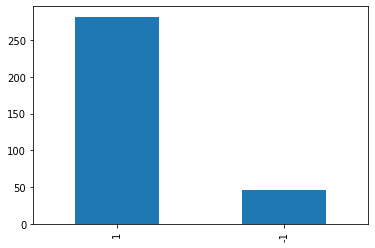

In [42]:
# -1 -> not paid; 1 -> paid
complete['loan status'].value_counts().plot(kind='bar')

#### Remarks:

### 1.4.13 Number of district inhabitants - Numerical Attribute

In [43]:
q3, q1 = np.percentile(complete['no. of inhabitants'], [75 ,25])

print("Min: ", end="");                 print(complete['no. of inhabitants'].min())
print("Max: ", end="");                 print(complete['no. of inhabitants'].max())
print("Mean: ", end="");                print(complete['no. of inhabitants'].mean())
print("Median: ", end="");              print(complete['no. of inhabitants'].median())
print("Standard deviation: ", end="");  print(complete['no. of inhabitants'].std())
print("Skewness: ", end="");            print(complete['no. of inhabitants'].skew())  
print("Variance: ", end="");            print(complete['no. of inhabitants'].var())
print("Kurtosis: ", end="");            print(complete['no. of inhabitants'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 42821
Max: 1204953
Mean: 288846.6981707317
Median: 125236.0
Standard deviation: 377966.15558948147
Skewness: 1.9275643050143925
Variance: 142858414771.0921
Kurtosis: 1.9645163409272448
Interquartile Range: 134719.5 | Q1: 92084.0 | Q3: 226803.5


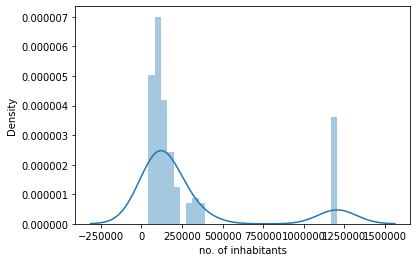

In [44]:
sns.distplot(complete['no. of inhabitants'])

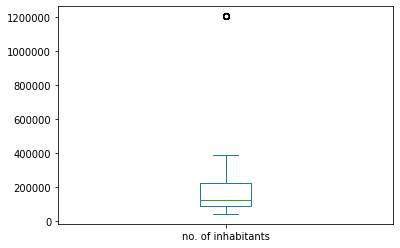

In [45]:
complete['no. of inhabitants'].plot.box();

#### Remarks:

### 1.4.14 Inahbitants per municipality - Numerical Attribute

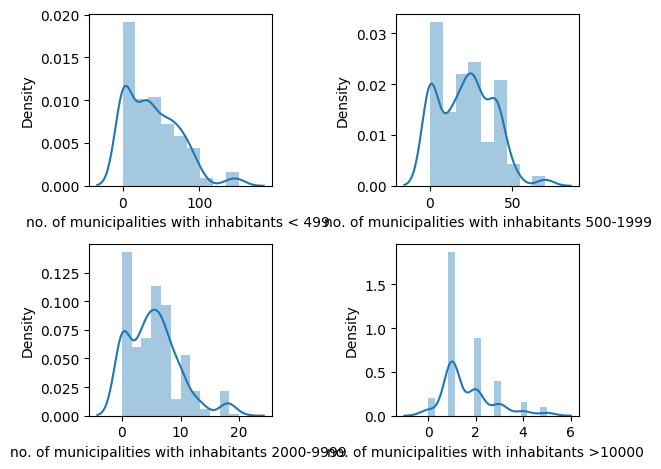

In [103]:
fig, ax = plt.subplots(2,2)
sns.distplot(complete['no. of municipalities with inhabitants < 499 '], ax=ax[0][0])
sns.distplot(complete['no. of municipalities with inhabitants 500-1999'], ax=ax[0][1])

sns.distplot(complete['no. of municipalities with inhabitants 2000-9999 '], ax=ax[1][0])
sns.distplot(complete['no. of municipalities with inhabitants >10000 '], ax=ax[1][1])
fig.tight_layout()
fig.show()

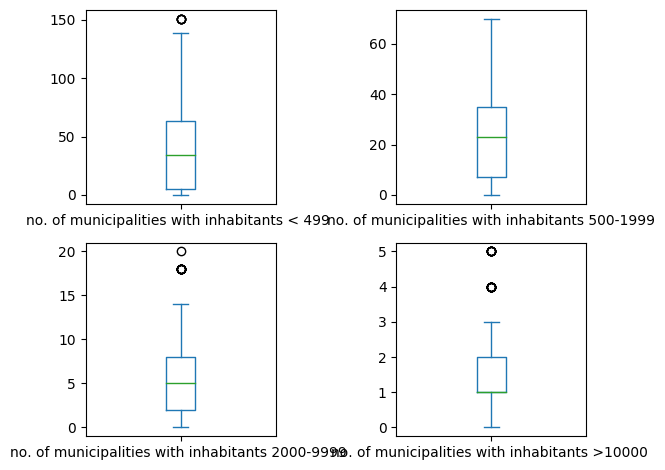

In [108]:
complete[['no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ']].plot(kind='box', subplots=True, legend=False, layout=(2, 2))
plt.tight_layout()

#### Remarks:

### 1.4.15 Number of cities of district - Numerical Attribute

In [46]:
q3, q1 = np.percentile(complete['no. of cities '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of cities '].min())
print("Max: ", end="");                 print(complete['no. of cities '].max())
print("Mean: ", end="");                print(complete['no. of cities '].mean())
print("Median: ", end="");              print(complete['no. of cities '].median())
print("Standard deviation: ", end="");  print(complete['no. of cities '].std())
print("Skewness: ", end="");            print(complete['no. of cities '].skew())  
print("Variance: ", end="");            print(complete['no. of cities '].var())
print("Kurtosis: ", end="");            print(complete['no. of cities '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 1
Max: 11
Mean: 5.219512195121951
Median: 5.0
Standard deviation: 2.8863249873450734
Skewness: -0.01195801679483785
Variance: 8.330871932572538
Kurtosis: -0.9696877864885023
Interquartile Range: 3.0 | Q1: 4.0 | Q3: 7.0


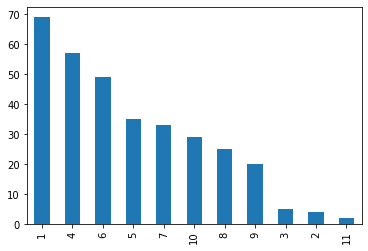

In [47]:
complete['no. of cities '].value_counts().plot(kind='bar')

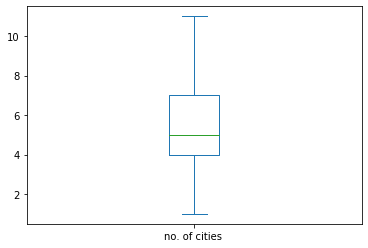

In [48]:
complete['no. of cities '].plot.box();

#### Remarks:

### 1.4.16 Ratio of Urban Inhabitants - Numerical Attribute

In [49]:
q3, q1 = np.percentile(complete['ratio of urban inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['ratio of urban inhabitants '].min())
print("Max: ", end="");                 print(complete['ratio of urban inhabitants '].max())
print("Mean: ", end="");                print(complete['ratio of urban inhabitants '].mean())
print("Median: ", end="");              print(complete['ratio of urban inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['ratio of urban inhabitants '].std())
print("Skewness: ", end="");            print(complete['ratio of urban inhabitants '].skew())  
print("Variance: ", end="");            print(complete['ratio of urban inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['ratio of urban inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 33.9
Max: 100.0
Mean: 68.64939024390245
Median: 62.0
Standard deviation: 20.573454577834134
Skewness: 0.3407628249222313
Variance: 423.26703326620424
Kurtosis: -1.166292715416102
Interquartile Range: 35.25 | Q1: 53.0 | Q3: 88.25


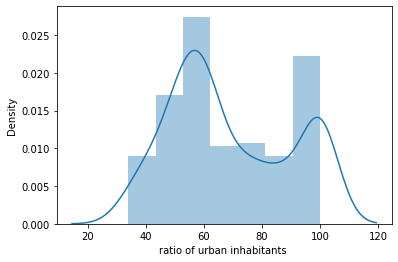

In [50]:
sns.distplot(complete['ratio of urban inhabitants '])

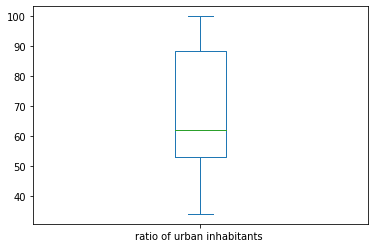

In [51]:
complete['ratio of urban inhabitants '].plot.box();

#### Remarks:

### 1.4.17 Average Salary - Numerical Attribute

In [52]:
q3, q1 = np.percentile(complete['average salary '], [75 ,25])

print("Min: ", end="");                 print(complete['average salary '].min())
print("Max: ", end="");                 print(complete['average salary '].max())
print("Mean: ", end="");                print(complete['average salary '].mean())
print("Median: ", end="");              print(complete['average salary '].median())
print("Standard deviation: ", end="");  print(complete['average salary '].std())
print("Skewness: ", end="");            print(complete['average salary '].skew())  
print("Variance: ", end="");            print(complete['average salary '].var())
print("Kurtosis: ", end="");            print(complete['average salary '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 8110
Max: 12541
Mean: 9593.338414634147
Median: 9019.5
Standard deviation: 1359.2325765121705
Skewness: 1.2456934836516622
Variance: 1847513.197051913
Kurtosis: 0.3720189164351839
Interquartile Range: 1399.0 | Q1: 8552.25 | Q3: 9951.25


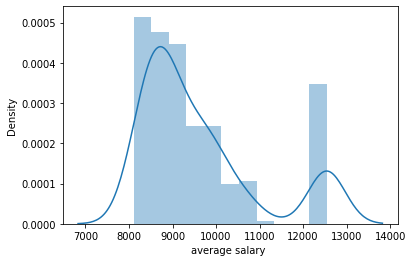

In [53]:
sns.distplot(complete['average salary '])

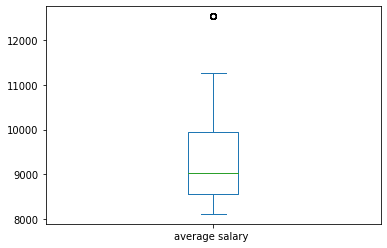

In [54]:
complete['average salary '].plot.box();

#### Remarks:

### 1.4.18 Unemploymant Rate - Numerical Attribute

In [55]:
complete.loc[complete["unemploymant rate '95 "] == '?', "unemploymant rate '95 "] = complete["unemploymant rate '96 "]
complete.loc[complete["unemploymant rate '96 "] == '?', "unemploymant rate '96 "] = complete["unemploymant rate '95 "]

#### Obtain the average of 95' and 96' columns

In [56]:
complete["unemploymant rate"] = (complete["unemploymant rate '95 "].astype('float') + complete["unemploymant rate '96 "].astype('float')) / 2.0
complete = complete.drop(columns=["unemploymant rate '95 ", "unemploymant rate '96 "])
# complete

#### Remarks:

### 1.4.19 Number of enterpreneurs per 1000 inhabitants - Numerical Attribute

In [57]:
q3, q1 = np.percentile(complete['no. of enterpreneurs per 1000 inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].min())
print("Max: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].max())
print("Mean: ", end="");                print(complete['no. of enterpreneurs per 1000 inhabitants '].mean())
print("Median: ", end="");              print(complete['no. of enterpreneurs per 1000 inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['no. of enterpreneurs per 1000 inhabitants '].std())
print("Skewness: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].skew())  
print("Variance: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 81
Max: 167
Mean: 122.75914634146342
Median: 115.5
Standard deviation: 23.951657004791024
Skewness: 0.5916848426357383
Variance: 573.6818732751549
Kurtosis: -0.6495980694707746
Interquartile Range: 33.0 | Q1: 107.0 | Q3: 140.0


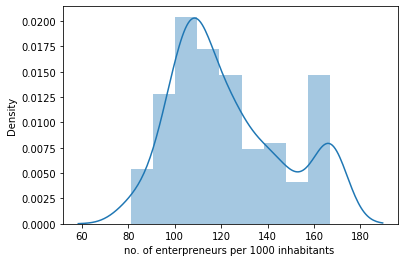

In [58]:
sns.distplot(complete['no. of enterpreneurs per 1000 inhabitants '])

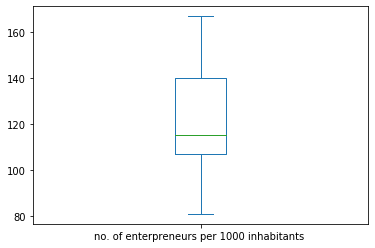

In [59]:
complete['no. of enterpreneurs per 1000 inhabitants '].plot.box();

#### Remarks:

### 1.4.20 Number of commited crimes per capita - Numerical Attribute

In [60]:
complete.loc[complete["no. of commited crimes '95 "] == '?', "no. of commited crimes '95 "] = complete["no. of commited crimes '96 "]
complete.loc[complete["no. of commited crimes '96 "] == '?', "no. of commited crimes '96 "] = complete["no. of commited crimes '95 "]

#### Obtain the average of 95' and 96' columns and then divide by the number of inhabitants

In [61]:
complete["no. of commited crimes per capita"] = (complete["no. of commited crimes '95 "].astype('float') + complete["no. of commited crimes '96 "].astype('float')) / 2.0 / complete["no. of inhabitants"]
complete = complete.drop(columns=["no. of commited crimes '95 ", "no. of commited crimes '96 "])
# complete

#### Remarks:

### 1.4.21 Card Type - Numerical Attribute

In [62]:
complete['card type'].describe()

count          11
unique          3
top       classic
freq            8
Name: card type, dtype: object

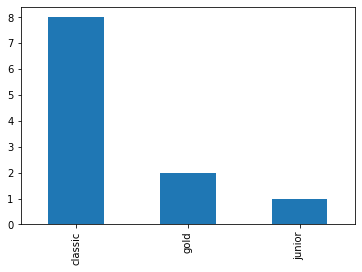

In [63]:
complete['card type'].value_counts().plot(kind='bar')

#### Filling Missing Values with 'None'

In [64]:
complete['card type'] = complete['card type'].fillna('None')

In [65]:
complete['card type'].value_counts()

None       317
classic      8
gold         2
junior       1
Name: card type, dtype: int64

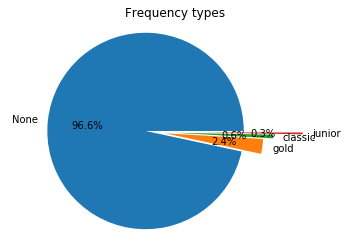

In [66]:
fig, ax = plt.subplots()
ax.pie(complete['card type'].value_counts(), labels=complete['card type'].unique(), autopct='%1.1f%%', explode = [0.1,0.1,0.2,0.5])
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Frequency types')

plt.show()

#### Remarks:

### 1.4.22 Birthdate - Date Attribute

In [67]:
complete['birthdate'].describe()

count            328
unique           318
top       1945-02-04
freq               2
Name: birthdate, dtype: object

In [68]:
print("Min: ", end="");                 print(complete['birthdate'].min())
print("Max: ", end="");                 print(complete['birthdate'].max())

Min: 1935-01-29
Max: 1980-12-07


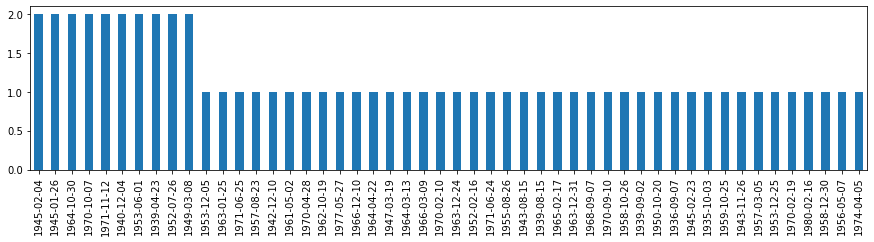

In [69]:
complete['birthdate'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:

### 1.4.23 Client Sex - Nominal Categorical Attribute

In [70]:
complete['sex'].describe()

count     328
unique      2
top         M
freq      166
Name: sex, dtype: object

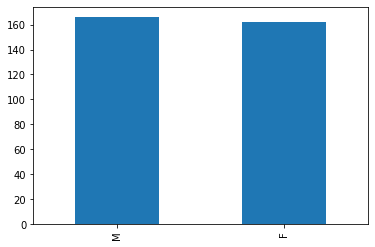

In [71]:
complete['sex'].value_counts().plot(kind='bar')

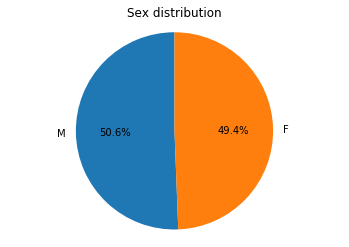

In [72]:
fig, ax = plt.subplots()
ax.pie(complete['sex'].value_counts(), labels=complete['sex'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Sex distribution')

plt.show()

#### Remarks:

### 1.4.23 Account has disponent or not - Nominal Categorical Attribute

In [73]:
complete['has disponent'].describe()

count       328
unique        2
top       False
freq        253
Name: has disponent, dtype: object

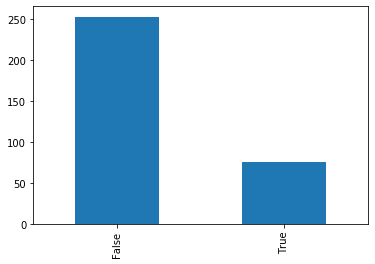

In [74]:
complete['has disponent'].value_counts().plot(kind='bar')

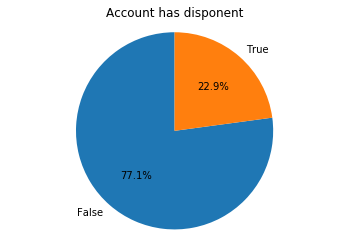

In [75]:
fig, ax = plt.subplots()
ax.pie(complete['has disponent'].value_counts(), labels=complete['has disponent'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Account has disponent')

plt.show()

In [77]:
temp = complete[['sex', 'loan status']]

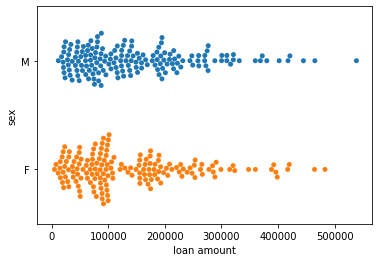

In [78]:
sns.swarmplot(x="loan amount", y="sex", data=complete[['sex', 'loan amount']])

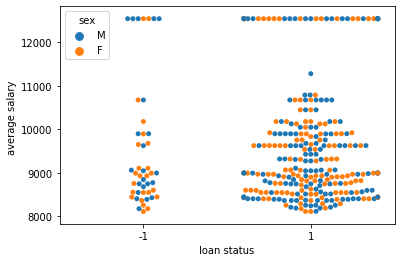

In [79]:
ax = sns.swarmplot(x="loan status", y="average salary ", hue="sex", data=complete[['average salary ', 'loan status', 'sex']])

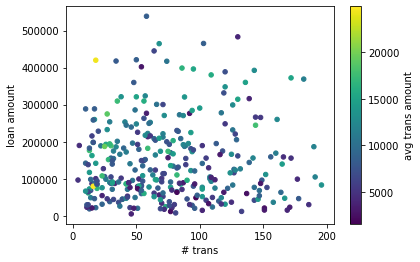

In [80]:
# Number of transactions, loan amount, avg amount per transaction

fig, ax = plt.subplots()
complete.plot(kind='scatter',x='# trans', y='loan amount', c='avg trans amount', colormap='viridis', ax=ax)
ax.set_xlabel("# trans")
plt.show()

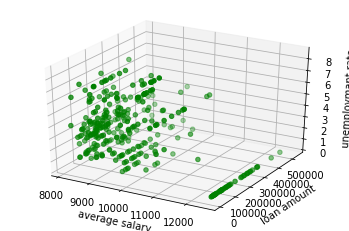

In [81]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(complete['average salary '], complete['loan amount'], complete["unemploymant rate"], c='g', marker='o')

ax.set_xlabel('average salary')
ax.set_ylabel('loan amount')
ax.set_zlabel('unemploymant rate')


plt.show()

#### Missing Values

In [82]:
total = complete.isnull().sum().sort_values(ascending=False)
percent = (complete.isnull().sum()/complete.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Total number of rows: ", end=""); print(complete.shape[0])
missing_data.head(10)

Total number of rows: 328


,Total,Percent
frequency,0,0.0
average salary,0,0.0
no. of municipalities with inhabitants < 499,0,0.0
no. of municipalities with inhabitants 500-1999,0,0.0
no. of municipalities with inhabitants 2000-9999,0,0.0
no. of municipalities with inhabitants >10000,0,0.0
no. of cities,0,0.0
ratio of urban inhabitants,0,0.0
no. of enterpreneurs per 1000 inhabitants,0,0.0
date,0,0.0


In [83]:
df_num = complete.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan amount,loan duration (mths),loan payments,loan status,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,age at loan (Years),unemploymant rate,no. of commited crimes per capita
0,53.0,1.0,0.0,11.0,0.0,31.0,28.0,3.0,22.0,17600.36,69954.57,79608,24,3317,1,105606,77,26,7,2,7,53.0,8254,97,23.570157,3.275,0.021263
1,56.0,3.0,0.0,10.0,6.0,27.0,32.0,1.0,23.0,5778.79,29069.12,149340,60,2489,1,105606,77,26,7,2,7,53.0,8254,97,31.178645,3.275,0.021263
2,60.0,2.0,0.0,10.0,0.0,38.0,33.0,5.0,22.0,13255.80,55570.30,77640,12,6470,1,105606,77,26,7,2,7,53.0,8254,97,26.904860,3.275,0.021263
3,117.0,26.0,0.0,0.0,0.0,71.0,70.0,1.0,46.0,10720.31,46487.00,277884,36,7719,-1,105606,77,26,7,2,7,53.0,8254,97,15.583847,3.275,0.021263
4,130.0,40.0,0.0,0.0,12.0,62.0,72.0,2.0,56.0,15168.36,63527.42,314520,60,5242,1,105606,77,26,7,2,7,53.0,8254,97,39.871321,3.275,0.021263


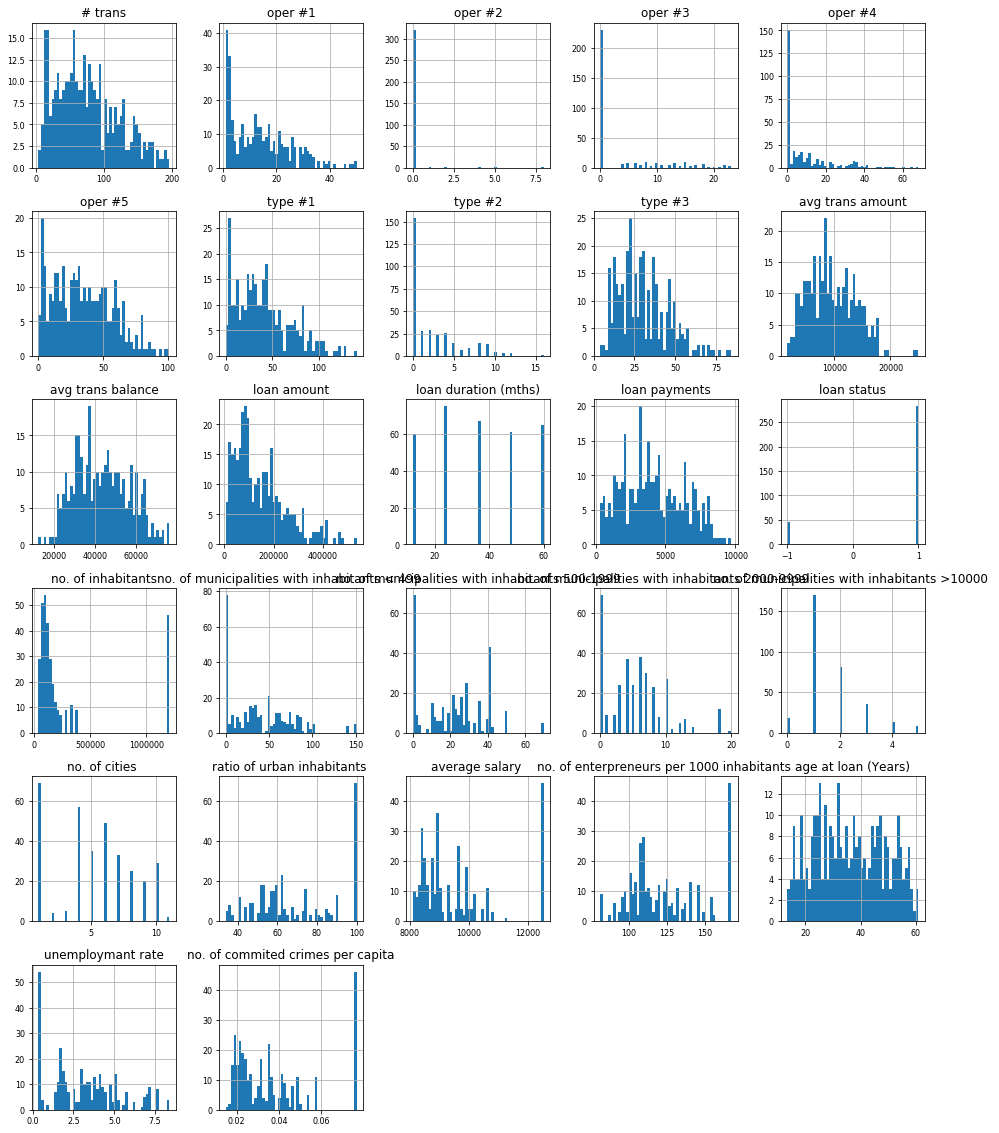

In [84]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [85]:
corr = complete.corr()['loan status']
corr

# trans                                              0.091208
oper #1                                             -0.051181
oper #2                                              0.048169
oper #3                                              0.137795
oper #4                                              0.182415
oper #5                                              0.058313
type #1                                              0.131617
type #2                                             -0.037240
type #3                                              0.019421
avg trans amount                                     0.039858
avg trans balance                                    0.193985
loan amount                                         -0.128237
loan duration (mths)                                -0.003537
loan payments                                       -0.168436
loan status                                          1.000000
no. of inhabitants                                  -0.009869
no. of m

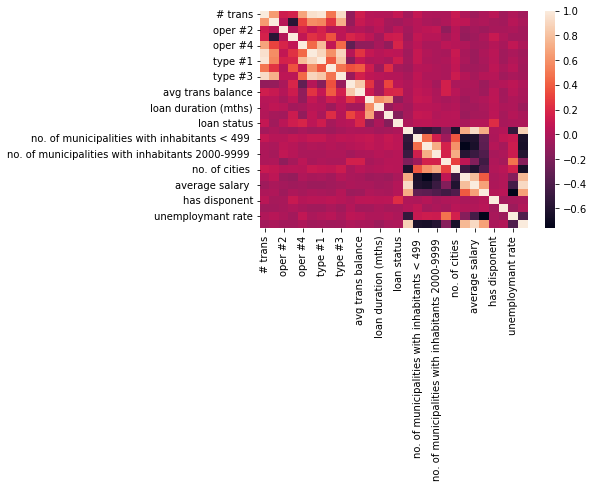

In [86]:
sns.heatmap(complete.corr(method='pearson'))

#### Outliers

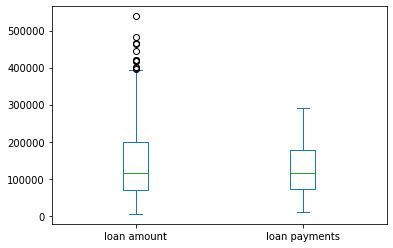

In [87]:
subset = complete[['loan amount', 'loan payments']]
subset['loan payments'] = subset['loan payments'] * 30
subset.plot.box();

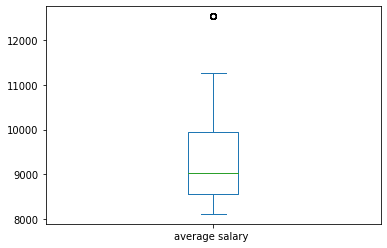

In [88]:
complete['average salary '].plot.box();

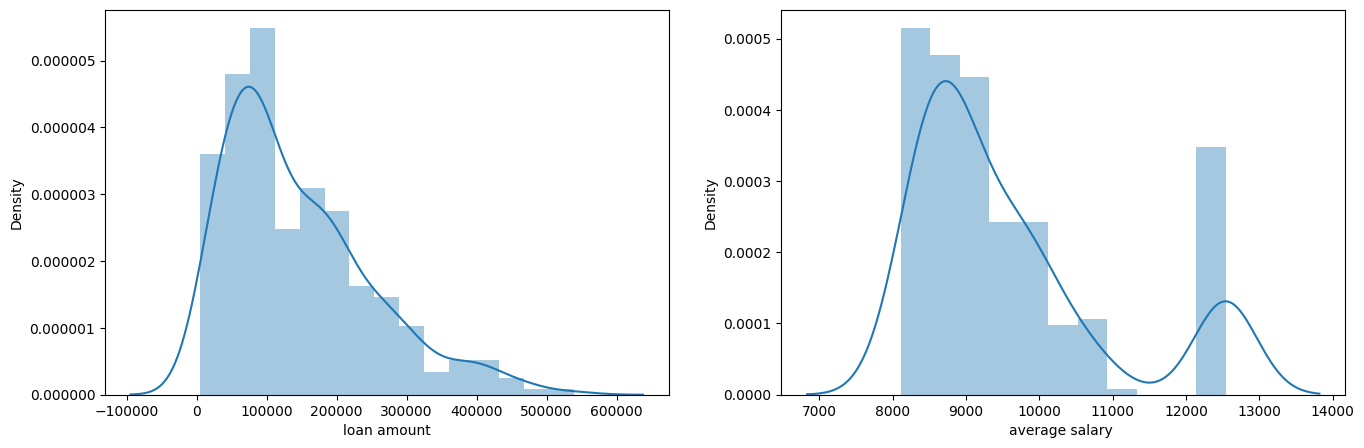

In [89]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(complete['loan amount'])
plt.subplot(1,2,2)
sns.distplot(complete['average salary '])
plt.show()

In [90]:
# Finding how many 
df_mask = complete['average salary '] > 12000
# print(len(complete[df_mask].index))
complete[df_mask]

,frequency,date,# trans,oper #1,oper #2,oper #3,oper #4,oper #5,type #1,type #2,type #3,avg trans amount,avg trans balance,loan date,loan amount,loan duration (mths),loan payments,loan status,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,card type,birthdate,sex,has disponent,age at loan (Years),unemploymant rate,no. of commited crimes per capita
36,monthly issuance,1993-02-04,115.0,21.0,0.0,0.0,23.0,39.0,62.0,0.0,53.0,8275.28,48944.83,1994-07-11,39576,12,3298,1,1204953,0,0,0,1,1,100.0,12541,167,None,1980-05-02,F,False,14.190281,0.36,0.076677
37,weekly issuance,1993-02-07,85.0,3.0,0.0,15.0,0.0,52.0,46.0,6.0,33.0,9434.44,43944.89,1994-06-01,208320,48,4340,1,1204953,0,0,0,1,1,100.0,12541,167,None,1968-04-14,F,True,26.130048,0.36,0.076677
38,weekly issuance,1993-02-14,27.0,1.0,0.0,6.0,3.0,11.0,14.0,0.0,13.0,18945.97,57188.21,1993-09-06,274740,60,4579,1,1204953,0,0,0,1,1,100.0,12541,167,None,1978-09-07,M,False,14.997947,0.36,0.076677
39,monthly issuance,1993-02-26,54.0,2.0,0.0,10.0,5.0,27.0,29.0,3.0,22.0,7954.26,32590.62,1994-01-05,80952,24,3373,1,1204953,0,0,0,1,1,100.0,12541,167,None,1945-02-04,M,True,48.917180,0.36,0.076677
40,monthly issuance,1993-02-26,54.0,2.0,0.0,10.0,5.0,27.0,29.0,3.0,22.0,7937.75,33312.54,1994-01-05,80952,24,3373,1,1204953,0,0,0,1,1,100.0,12541,167,None,1945-02-04,M,True,48.917180,0.36,0.076677
41,monthly issuance,1993-02-27,73.0,21.0,0.0,0.0,0.0,42.0,33.0,9.0,31.0,16201.56,55582.23,1994-01-10,24516,12,2043,1,1204953,0,0,0,1,1,100.0,12541,167,None,1958-10-07,M,False,35.260780,0.36,0.076677
42,monthly issuance,1993-03-13,153.0,13.0,0.0,22.0,36.0,60.0,89.0,7.0,57.0,6527.34,31375.16,1995-01-11,76416,24,3184,1,1204953,0,0,0,1,1,100.0,12541,167,None,1937-09-02,M,True,57.357974,0.36,0.076677
43,monthly issuance,1993-03-24,139.0,38.0,0.0,0.0,0.0,79.0,79.0,0.0,60.0,3872.07,18632.93,1995-02-05,316140,60,5269,-1,1204953,0,0,0,1,1,100.0,12541,167,None,1968-02-22,M,False,26.954141,0.36,0.076677
44,weekly issuance,1993-03-27,96.0,21.0,0.0,0.0,12.0,48.0,56.0,4.0,36.0,9301.09,40838.76,1994-08-05,120888,36,3358,1,1204953,0,0,0,1,1,100.0,12541,167,None,1944-04-20,F,False,50.291581,0.36,0.076677
45,monthly issuance,1993-04-22,133.0,19.0,0.0,0.0,38.0,59.0,97.0,0.0,36.0,6032.84,42224.44,1994-10-02,11736,24,489,1,1204953,0,0,0,1,1,100.0,12541,167,None,1938-09-16,M,False,56.043806,0.36,0.076677
